# Segmenting and Clustering Neighborhoods in Toronto

In [1]:
!pip3 install lxml
import pandas as pd
import numpy as np
import lxml
import matplotlib.cm as cm
import matplotlib.colors as colors

     |████████████████████████████████| 5.5 MB 4.3 MB/s eta 0:00:01


## 1.Scraping dataset from the url using pandas

In [2]:
url ='https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
df =pd.read_html(url)
df[0].to_csv('toronto.csv')
df =pd.read_csv('toronto.csv')
df.head()


,Unnamed: 0,Postal Code,Borough,Neighbourhood
0,0,M1A,Not assigned,Not assigned
1,1,M2A,Not assigned,Not assigned
2,2,M3A,North York,Parkwoods
3,3,M4A,North York,Victoria Village
4,4,M5A,Downtown Toronto,"Regent Park, Harbourfront"


### Droping useless data from the dataset

In [3]:
df.drop('Unnamed: 0',inplace =True, axis =1)
df.head()

,Postal Code,Borough,Neighbourhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"


In [4]:
df['Borough'].replace({'Not assigned':np.NaN},inplace =True)
df.dropna(inplace =True)
df= df.reset_index(drop=True)
df.head()

,Postal Code,Borough,Neighbourhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"


In [5]:
df.shape

(103, 3)

## 2. Adding lat and long for the postal codes in the dataset

In [6]:
!wget -q -O 'Geospatial_data.csv'  https://cocl.us/Geospatial_data

In [7]:
df2 = pd.read_csv('Geospatial_data.csv')
df2.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


#### we observe that the postal codes for the above datasets are arranged alphabetically.we sort the postal code column for the toronto dataset alphabetically so that postal code becomes the join key for merging the lat and long data into the toronto dataset

In [8]:
df =df.sort_values('Postal Code').reset_index()

In [9]:
df.drop('index',inplace =True,axis =1)

In [10]:
df =pd.merge(df,df2, on ='Postal Code')

In [11]:
df.head()

,Postal Code,Borough,Neighbourhood,Latitude,Longitude
0,M1B,Scarborough,"Malvern, Rouge",43.806686,-79.194353
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476


In [12]:
df['Borough'].unique().tolist()

['Scarborough',
 'North York',
 'East York',
 'East Toronto',
 'Central Toronto',
 'Downtown Toronto',
 'York',
 'West Toronto',
 'Mississauga',
 'Etobicoke']

In [13]:
!pip install folium==0.5.0

     |████████████████████████████████| 79 kB 2.0 MB/s eta 0:00:011
  Created wheel for folium: filename=folium-0.5.0-py3-none-any.whl size=76240 sha256=c4db3865f8731a6a39884fc0639c384ed5bf95761f0a92bffc72304921d5327c
  Stored in directory: /home/jovyan/.cache/pip/wheels/b2/2f/2c/109e446b990d663ea5ce9b078b5e7c1a9c45cca91f377080f8
Successfully built folium


## we plot the coordinates of the boroughs in a map of toronto

In [14]:
import folium

In [15]:
toronto_lat,toronto_long =43.6534817, -79.3839347 #since geopy wasn't working for me..i am directly assigning the Toronto coordinates

In [16]:
map_tor =folium.Map(location=[toronto_lat,toronto_long],zoom_start=10)

for lat,lng,borough,neighb in zip(df['Latitude'],df['Longitude'],df['Borough'],df['Neighbourhood']):
    label = '{},{}'.format(neighb,borough)
    label = folium.Popup(label,parse_html =True)
    folium.CircleMarker(
    [lat,lng],
    radius =5,
    popup=label,
    color='blue',
    fill =True,
    fill_color ='#3186cc',
    fill_opacity =0.7,
    parse_html =False    
    ).add_to(map_tor)

In [17]:
map_tor

In [18]:
CLIENT_ID = '1PIBVWP4YDT4VEFL5KDLC5IUBMHBRAR5SLGF3HA2VEO4QSEJ' 
CLIENT_SECRET = 'QC2CZYTPYXIJWGHYCNLSQLSD4PF3LI4K4UJ3FZ3MN3BFJ3NN'
VERSION = '20180605' 
LIMIT = 100 

## we use foursquare api to get a list of all the venues in all the boroughs..and implement a userdefined function to to store the venues in a dataframe with their respective latitude and longitude 

In [19]:
import requests
from pandas.io.json import json_normalize

In [20]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lati, lngi in zip(names, latitudes, longitudes):
        print(name)
            

        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lati, 
            lngi, 
            radius, 
            LIMIT)
            
    
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighbourhood', 
                  'Neighbourhood Latitude', 
                  'Neighbourhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [21]:
toronto_venue =getNearbyVenues(names =df['Neighbourhood'],
                              latitudes =df['Latitude'],
                              longitudes =df['Longitude'])

Malvern, Rouge
Rouge Hill, Port Union, Highland Creek
Guildwood, Morningside, West Hill
Woburn
Cedarbrae
Scarborough Village
Kennedy Park, Ionview, East Birchmount Park
Golden Mile, Clairlea, Oakridge
Cliffside, Cliffcrest, Scarborough Village West
Birch Cliff, Cliffside West
Dorset Park, Wexford Heights, Scarborough Town Centre
Wexford, Maryvale
Agincourt
Clarks Corners, Tam O'Shanter, Sullivan
Milliken, Agincourt North, Steeles East, L'Amoreaux East
Steeles West, L'Amoreaux West
Upper Rouge
Hillcrest Village
Fairview, Henry Farm, Oriole
Bayview Village
York Mills, Silver Hills
Willowdale, Newtonbrook
Willowdale, Willowdale East
York Mills West
Willowdale, Willowdale West
Parkwoods
Don Mills
Don Mills
Bathurst Manor, Wilson Heights, Downsview North
Northwood Park, York University
Downsview
Downsview
Downsview
Downsview
Victoria Village
Parkview Hill, Woodbine Gardens
Woodbine Heights
The Beaches
Leaside
Thorncliffe Park
East Toronto, Broadview North (Old East York)
The Danforth West, 

In [22]:
toronto_venue.head()

,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"Malvern, Rouge",43.706748,-79.594054,Wendy’s,43.807448,-79.199056,Fast Food Restaurant
1,"Malvern, Rouge",43.706748,-79.594054,Interprovincial Group,43.805630,-79.200378,Print Shop
2,"Rouge Hill, Port Union, Highland Creek",43.706748,-79.594054,Chris Effects Painting,43.784343,-79.163742,Construction & Landscaping
3,"Rouge Hill, Port Union, Highland Creek",43.706748,-79.594054,Royal Canadian Legion,43.782533,-79.163085,Bar
4,"Guildwood, Morningside, West Hill",43.706748,-79.594054,RBC Royal Bank,43.766790,-79.191151,Bank


## List of all the unique venue category in toronto

In [23]:
toronto_venue['Venue Category'].unique().tolist()

['Fast Food Restaurant',
 'Print Shop',
 'Construction & Landscaping',
 'Bar',
 'Bank',
 'Restaurant',
 'Mexican Restaurant',
 'Rental Car Location',
 'Medical Center',
 'Intersection',
 'Breakfast Spot',
 'Coffee Shop',
 'Korean BBQ Restaurant',
 'Pharmacy',
 'Caribbean Restaurant',
 'Hakka Restaurant',
 'Thai Restaurant',
 'Athletics & Sports',
 'Gas Station',
 'Bakery',
 'Fried Chicken Joint',
 'Playground',
 'Grocery Store',
 'Jewelry Store',
 'Department Store',
 'Bus Station',
 'Ice Cream Shop',
 'Bus Line',
 'Metro Station',
 'Park',
 'Soccer Field',
 'Motel',
 'American Restaurant',
 'Café',
 'General Entertainment',
 'Farm',
 'Skating Rink',
 'College Stadium',
 'Chinese Restaurant',
 'Indian Restaurant',
 'Vietnamese Restaurant',
 'Pet Store',
 'Light Rail Station',
 'Sandwich Place',
 'Middle Eastern Restaurant',
 'Shopping Mall',
 'Auto Garage',
 'Latin American Restaurant',
 'Lounge',
 'Italian Restaurant',
 'Noodle House',
 'Pizza Place',
 'Convenience Store',
 'Electroni

In [24]:
toronto_venue.groupby('Neighbourhood').count()

,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighbourhood,,,,,,
Agincourt,4,4,4,4,4,4
"Alderwood, Long Branch",8,8,8,8,8,8
"Bathurst Manor, Wilson Heights, Downsview North",22,22,22,22,22,22
Bayview Village,4,4,4,4,4,4
"Bedford Park, Lawrence Manor East",23,23,23,23,23,23
Berczy Park,58,58,58,58,58,58
"Birch Cliff, Cliffside West",5,5,5,5,5,5
"Brockton, Parkdale Village, Exhibition Place",23,23,23,23,23,23
"Business reply mail Processing Centre, South Central Letter Processing Plant Toronto",16,16,16,16,16,16


## we now implement one hot encoding to anaylyze the occurence of the top ten venues in each neighbourhood

In [25]:
toronto_onehot1 =pd.get_dummies(toronto_venue[['Venue Category']],prefix ='',prefix_sep='')
toronto_onehot1.pop('Neighborhood')
toronto_onehot1.insert(0,'Neighbourhood',toronto_venue['Neighbourhood'])
toronto_onehot1.head()

,Neighbourhood,Accessories Store,Adult Boutique,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,...,Truck Stop,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wings Joint,Women's Store,Yoga Studio
0,"Malvern, Rouge",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,"Malvern, Rouge",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,"Rouge Hill, Port Union, Highland Creek",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,"Rouge Hill, Port Union, Highland Creek",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,"Guildwood, Morningside, West Hill",0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [26]:
toronto_grouped =toronto_onehot1.groupby('Neighbourhood').mean().reset_index()
toronto_grouped


,Neighbourhood,Accessories Store,Adult Boutique,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,...,Truck Stop,Turkish Restaurant,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wings Joint,Women's Store,Yoga Studio
0,Agincourt,0.0,0.0000,0.0000,0.000000,0.0000,0.0000,0.000,0.0000,0.000,...,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
1,"Alderwood, Long Branch",0.0,0.0000,0.0000,0.000000,0.0000,0.0000,0.000,0.0000,0.000,...,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
2,"Bathurst Manor, Wilson Heights, Downsview North",0.0,0.0000,0.0000,0.000000,0.0000,0.0000,0.000,0.0000,0.000,...,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
3,Bayview Village,0.0,0.0000,0.0000,0.000000,0.0000,0.0000,0.000,0.0000,0.000,...,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
4,"Bedford Park, Lawrence Manor East",0.0,0.0000,0.0000,0.000000,0.0000,0.0000,0.000,0.0000,0.000,...,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
5,Berczy Park,0.0,0.0000,0.0000,0.000000,0.0000,0.0000,0.000,0.0000,0.000,...,0.0,0.0,0.017241,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
6,"Birch Cliff, Cliffside West",0.0,0.0000,0.0000,0.000000,0.0000,0.0000,0.000,0.0000,0.000,...,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
7,"Brockton, Parkdale Village, Exhibition Place",0.0,0.0000,0.0000,0.000000,0.0000,0.0000,0.000,0.0000,0.000,...,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000
8,"Business reply mail Processing Centre, South C...",0.0,0.0000,0.0000,0.000000,0.0000,0.0000,0.000,0.0000,0.000,...,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.062500
9,"CN Tower, King and Spadina, Railway Lands, Har...",0.0,0.0000,0.0000,0.062500,0.0625,0.0625,0.125,0.1875,0.125,...,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000


In [27]:
def return_most_common_venues(row, num_top_ten):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_ten]

In [28]:
num_top_ten =10
indicators =['st','nd','rd']
columns =['Neighbourhood']
for inp in np.arange(num_top_ten):
    try:
        columns.append('{}{} Most Common Venue'.format(inp+1, indicators[inp]))
    except:
        columns.append('{}th Most Common Venue'.format(inp+1))

toronto_venue_sorted = pd.DataFrame(columns=columns)
toronto_venue_sorted['Neighbourhood'] = toronto_grouped['Neighbourhood']

for ind in np.arange(toronto_grouped.shape[0]):
    toronto_venue_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_ten)

toronto_venue_sorted.head()

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Agincourt,Latin American Restaurant,Skating Rink,Breakfast Spot,Lounge,Yoga Studio,Dog Run,Dim Sum Restaurant,Diner,Discount Store,Distribution Center
1,"Alderwood, Long Branch",Pizza Place,Gym,Skating Rink,Coffee Shop,Pub,Sandwich Place,Pharmacy,Airport Lounge,Airport Service,Escape Room
2,"Bathurst Manor, Wilson Heights, Downsview North",Bank,Coffee Shop,Fried Chicken Joint,Diner,Supermarket,Ice Cream Shop,Sushi Restaurant,Mobile Phone Shop,Shopping Mall,Restaurant
3,Bayview Village,Café,Japanese Restaurant,Bank,Chinese Restaurant,Yoga Studio,Dessert Shop,Diner,Discount Store,Distribution Center,Dog Run
4,"Bedford Park, Lawrence Manor East",Italian Restaurant,Coffee Shop,Sandwich Place,Cosmetics Shop,Juice Bar,Butcher,Café,Sushi Restaurant,Pub,Liquor Store


## we can determine the best k for the dataset by impleminting the elbow method and silhouette method for determining k.

In [29]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt 

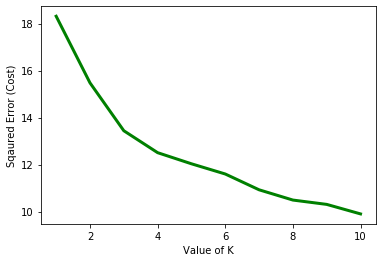

In [81]:
toronto_grouped_clustering =toronto_grouped.drop('Neighbourhood',1)
cost =[] 
#elbow method for determining k
for i in range(1,11):
    KM = KMeans(n_clusters = i,random_state=3) 
    KM.fit(toronto_grouped_clustering) 
      
    # calculates squared error 
    # for the clustered points 
    cost.append(KM.inertia_)      
  
# plot the cost against K values 
plt.plot(range(1, 11), cost, color ='g', linewidth ='3') 
plt.xlabel("Value of K") 
plt.ylabel("Sqaured Error (Cost)") 
plt.show()

### The elbow point seems to be near k=4

In [79]:
#silhouette method for confirming k
from sklearn.metrics import silhouette_score

sil = []
kmax = 10

for k in range(2, kmax+1):
  kmeans = KMeans(n_clusters = k,random_state=3).fit(toronto_grouped_clustering)
  labels = kmeans.labels_
  sil.append(silhouette_score(toronto_grouped_clustering, labels, metric = 'euclidean'))


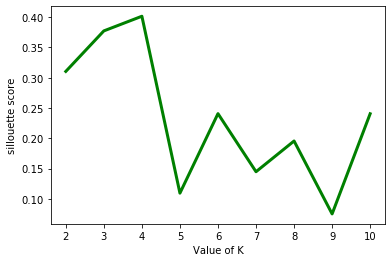

In [80]:
sil
plt.plot(range(2, kmax+1),sil,color ='g',linewidth ='3')
plt.xlabel("Value of K") 
plt.ylabel("sillouette score") 
plt.show()

### The highest silhouette seems to be near k=4

In [83]:
k = 4
kmean =KMeans(n_clusters = k,random_state=3).fit(toronto_grouped_clustering)
kmean.labels_


array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 2,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2,
       1, 2, 1, 1, 1, 1, 2, 0], dtype=int32)

In [86]:
toronto_venue_sorted.insert(0,'Cluster Labels',kmean.labels_)
toronto_merged = df
toronto_merged = toronto_merged.join(toronto_venue_sorted.set_index('Neighbourhood'),on='Neighbourhood')
toronto_merged.head()

,Postal Code,Borough,Neighbourhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M1B,Scarborough,"Malvern, Rouge",43.806686,-79.194353,1.0,Print Shop,Fast Food Restaurant,Yoga Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497,1.0,Construction & Landscaping,Bar,Yoga Studio,Donut Shop,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Drugstore
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711,1.0,Mexican Restaurant,Restaurant,Rental Car Location,Breakfast Spot,Medical Center,Intersection,Bank,Yoga Studio,Diner,Discount Store
3,M1G,Scarborough,Woburn,43.770992,-79.216917,1.0,Coffee Shop,Pharmacy,Korean BBQ Restaurant,Doner Restaurant,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Drugstore
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476,1.0,Fried Chicken Joint,Gas Station,Hakka Restaurant,Bakery,Athletics & Sports,Bank,Thai Restaurant,Caribbean Restaurant,Dim Sum Restaurant,Diner


In [87]:
toronto_merged.dropna(inplace=True)
toronto_merged['Cluster Labels']=toronto_merged['Cluster Labels'].astype(int)

In [88]:
toronto_merged.head()

,Postal Code,Borough,Neighbourhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M1B,Scarborough,"Malvern, Rouge",43.806686,-79.194353,1,Print Shop,Fast Food Restaurant,Yoga Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant
1,M1C,Scarborough,"Rouge Hill, Port Union, Highland Creek",43.784535,-79.160497,1,Construction & Landscaping,Bar,Yoga Studio,Donut Shop,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Drugstore
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711,1,Mexican Restaurant,Restaurant,Rental Car Location,Breakfast Spot,Medical Center,Intersection,Bank,Yoga Studio,Diner,Discount Store
3,M1G,Scarborough,Woburn,43.770992,-79.216917,1,Coffee Shop,Pharmacy,Korean BBQ Restaurant,Doner Restaurant,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Drugstore
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476,1,Fried Chicken Joint,Gas Station,Hakka Restaurant,Bakery,Athletics & Sports,Bank,Thai Restaurant,Caribbean Restaurant,Dim Sum Restaurant,Diner


## we plot the clustered datapoints in the toronto map

In [89]:
map_clusters = folium.Map(location=[toronto_lat,toronto_long], zoom_start=11)

# set color scheme for the clusters
x = np.arange(k)
ys = [i + x + (i*x)**2 for i in range(k)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighbourhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## Area with multiple facility

In [90]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 0, toronto_merged.columns[[2] + list(range(5, toronto_merged.shape[1]))]]

,Neighbourhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
20,"York Mills, Silver Hills",0,Cafeteria,Deli / Bodega,Ethiopian Restaurant,Escape Room,Electronics Store,Eastern European Restaurant,Drugstore,Donut Shop,Doner Restaurant,Dog Run


## Areas with most diverse restaurant options

In [91]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 1, toronto_merged.columns[[2] + list(range(5, toronto_merged.shape[1]))]]

,Neighbourhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Malvern, Rouge",1,Print Shop,Fast Food Restaurant,Yoga Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant
1,"Rouge Hill, Port Union, Highland Creek",1,Construction & Landscaping,Bar,Yoga Studio,Donut Shop,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Drugstore
2,"Guildwood, Morningside, West Hill",1,Mexican Restaurant,Restaurant,Rental Car Location,Breakfast Spot,Medical Center,Intersection,Bank,Yoga Studio,Diner,Discount Store
3,Woburn,1,Coffee Shop,Pharmacy,Korean BBQ Restaurant,Doner Restaurant,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Drugstore
4,Cedarbrae,1,Fried Chicken Joint,Gas Station,Hakka Restaurant,Bakery,Athletics & Sports,Bank,Thai Restaurant,Caribbean Restaurant,Dim Sum Restaurant,Diner
5,Scarborough Village,1,Grocery Store,Jewelry Store,Playground,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant
6,"Kennedy Park, Ionview, East Birchmount Park",1,Department Store,Bus Station,Playground,Coffee Shop,Dog Run,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center
7,"Golden Mile, Clairlea, Oakridge",1,Bakery,Soccer Field,Park,Bus Station,Intersection,Bus Line,Ice Cream Shop,Metro Station,Yoga Studio,Distribution Center
8,"Cliffside, Cliffcrest, Scarborough Village West",1,Motel,American Restaurant,Dog Run,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Doner Restaurant,Deli / Bodega
9,"Birch Cliff, Cliffside West",1,College Stadium,Farm,Café,Skating Rink,General Entertainment,Yoga Studio,Dog Run,Dim Sum Restaurant,Diner,Discount Store


## Areas with the most recreational venues

In [44]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 2, toronto_merged.columns[[2] + list(range(5, toronto_merged.shape[1]))]]

,Neighbourhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
21,"Willowdale, Newtonbrook",2,Park,Yoga Studio,Doner Restaurant,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Donut Shop
23,York Mills West,2,Convenience Store,Park,Yoga Studio,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop
40,"East Toronto, Broadview North (Old East York)",2,Convenience Store,Park,Yoga Studio,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Donut Shop
48,"Moore Park, Summerhill East",2,Gym,Park,Doner Restaurant,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Donut Shop
50,Rosedale,2,Park,Playground,Trail,Yoga Studio,Distribution Center,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store
74,Caledonia-Fairbanks,2,Park,Women's Store,Bar,Donut Shop,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Drugstore
90,"The Kingsway, Montgomery Road, Old Mill North",2,Park,River,Yoga Studio,Dog Run,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Doner Restaurant
98,Weston,2,Park,Yoga Studio,Doner Restaurant,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Donut Shop


## Areas with sports field

In [92]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 3, toronto_merged.columns[[2] + list(range(5, toronto_merged.shape[1]))]]

,Neighbourhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
91,"Old Mill South, King's Mill Park, Sunnylea, Hu...",3,Baseball Field,Donut Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Yoga Studio,Farm
97,"Humberlea, Emery",3,Baseball Field,Donut Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Doner Restaurant,Yoga Studio,Farm
